# Projekt "Analiza cen iPhone'ów na OLX"

W ramach projektu zbierzemy dane o sprzedaży iPhone'ów z serwisu OLX następnie zorientujemy się w średnich cenach za konkretna wersje i zasugerujemy najtansze telefony pod katem kazdej wersji

## Etap 1: Scrapowanie danych

W pierwszej kolejności wykorzystamy technikę webscrapingu do pobrania ofert sprzedaży iPhone'ów z serwisu OLX. Do tego celu wykorzystamy bibliotekę Pythona - BeautifulSoup.

In [2]:
from bs4 import BeautifulSoup
from requests import get
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import re
import numpy as np

In [89]:
URL= 'https://www.olx.pl/oferty/q-iphone-xs/'

In [ ]:
#11 X 12 13 8 xs

In [2]:
def parse_price(price):
    if price!="":    
        return float(price.replace(" ","").replace('zł','').replace('donegocjacji','').replace('Zamienię','0').replace(',','.').replace('Zadarmo','0'))
    else:
        return(0)

In [50]:
links=[]
titles =[]
places =[]
prices= []
versions =[]
dates=[]
negotiations=[]
stans=[]
Odsiwezans=[]


In [84]:
 def parse_page(number): 
    page = get(f'{URL}?page={number}')
    bs = BeautifulSoup(page.content, 'html.parser')
    
    for offer in bs.find_all('div', class_='css-1venxj6'):
        title = offer.find('h6',class_="css-16v5mdi er34gjf0").get_text()
        place = offer.find('p', class_='css-veheph er34gjf0').get_text().split('-')[0].split(',')[0]
        date  = offer.find('p', class_='css-veheph er34gjf0').get_text().split('-')[1]
        price_element = offer.find('p', class_='css-10b0gli er34gjf0')
        if price_element is not None:
                price = price_element.get_text()
        else:
            price = ""
    # Handle the case where the price element is not found
        stan  = offer.find('span',class_='css-3lkihg')
        Odswiezenie = False
        if stan is not None:
            stan1= stan.text
        else:
            stan1='x'
            
        if(date.find('Odświeżono')==1):
            date = date[17:]
            Odswiezenie = True
        dzisiaj = datetime.today()
        miesiace = ['stycznia', 'lutego', 'marca', 'kwietnia', 'maja', 'czerwca', 'lipca', 'sierpnia'
                    , 'wrzesnia', 'października', 'listopada', 'grudnia']
        dzisiajzm = str(dzisiaj.day)+" "+str(miesiace[dzisiaj.month - 1])+" "+str(dzisiaj.year)
        #print(dzisiaj.day, miesiace[dzisiaj.month - 1], dzisiaj.year)
        #######
        regex = r"[0-9]{2} [a-z]+ [0-9]{4}"
        if not re.match(regex, date):
            date = dzisiajzm
        #if(date.find("Dzisiaj")==1):
        #    date = dzisiajzm
        link =offer.parent.parent.parent.find('a', class_='css-rc5s2u')
        fulllink= 'https://www.olx.pl'+link['href']
        #print(link['href'])
        # print(fulllink,title,place)
        title = title.lower()
        version = title[title.find('iphone')+7:title.find('iphone')+9]
        version = version.replace(" ","").replace(',','').replace('+','').replace('p','').replace('/','')
        if(title.find('pro') != -1):
            version= version +' pro'
        if(title.find('plus') != -1):
            version= version +' plus'
        if(title.find('max') != -1):
            version= version +' max'
        if(title.find('mini') != -1):
            version= version +' mini'
        #print(title,version, parse_price(price))
        if(title.find('iphone') != -1):
            if(price.find('negocjacji') != -1):
                negotiations.append(True)
            else:
                negotiations.append(False)
            links.append(fulllink)
            titles.append(title)
            places.append(place)
            prices.append(parse_price(price))
            versions.append(version)
            dates.append(date)
            stans.append(stan1)
            Odsiwezans.append(Odswiezenie)
  



In [90]:
for page in range(1, 25):
    parse_page(page)


In [91]:
data = {'URL ogłoszenia':links,
        'Tytuł':titles,
        'Miejsce':places,
        'Data wstawienia':dates,
        'Wersja Iphona':versions,
        'Cena':prices,
        'Stan':stans,
        'Czy odświeżano ogłoszenie?':Odsiwezans,
        'Negocjacje': negotiations
}
df=pd.DataFrame(data)

Z uwagi iż olx do wyszukanej frazy pokaże tylko 25 stron wyników to użyłem funckji parse_page wpisujac rozne wersje dla ciekawszej analizy. Oczywiście w dalszej czesci usuniemy powstałe przez to duplikaty/

In [92]:
df

,URL ogłoszenia,Tytuł,Miejsce,Data wstawienia,Wersja Iphona,Cena,Stan,Czy odświeżano ogłoszenie?,Negocjacje
0,https://www.olx.pl/d/oferta/okazja-iphone-11-1...,okazja ! iphone 11 128 gb yellow 100% sprawny,Łódź,27 marca 2023,11,1450.0,Używane,False,False
1,https://www.olx.pl/d/oferta/apple-iphone-11-pr...,apple iphone 11 pro 64gb | gwar 24msc | bateri...,Aleksandrów Łódzki,27 marca 2023,11 pro,2099.0,Używane,False,False
2,https://www.olx.pl/d/oferta/szklo-iphone-11-11...,szkło iphone 11 / 11 pro max warszawa,Warszawa,27 marca 2023,11 pro max,10.0,Nowe,False,False
3,https://www.olx.pl/d/oferta/iphone-11-4gb-128-...,iphone 11 4gb/128,Wołomin,27 marca 2023,11,750.0,Używane,False,False
4,https://www.olx.pl/d/oferta/iphone-11-64gb-cza...,iphone 11 64gb czarny,Warszawa,27 marca 2023,11,900.0,Używane,False,False
...,...,...,...,...,...,...,...,...,...
7396,https://www.olx.pl/d/oferta/apple-iphone-xs-64...,apple iphone xs 64gb gold,Wrocław,27 marca 2023,xs,1299.0,Używane,False,False
7397,https://www.olx.pl/d/oferta/iphone-xs-ideal-CI...,iphone xs •ideał•,Gorzów Wielkopolski,27 marca 2023,xs,1500.0,Używane,False,False
7398,https://www.olx.pl/d/oferta/iphone-xs-max-256-...,iphone xs max 256 gb,Poznań,27 marca 2023,xs max,1300.0,Używane,False,False
7399,https://www.olx.pl/d/oferta/iphone-xs-256-gb-C...,iphone xs 256 gb,Janów,27 marca 2023,xs,1450.0,Używane,False,False


<AxesSubplot:xlabel='Cena', ylabel='Count'>

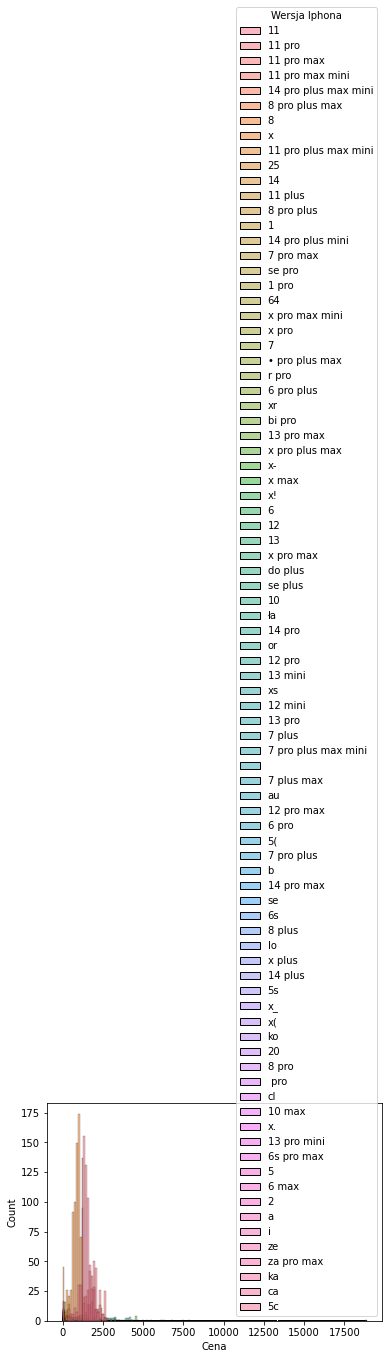

In [69]:
sns.histplot(data=df, x='Cena', hue='Wersja Iphona')

In [21]:
print(df['URL ogłoszenia'][322])

https://www.olx.pl/d/oferta/iphone-x-64gb-uzywani-CID99-IDTNr3X.html


<AxesSubplot:xlabel='Cena', ylabel='Count'>

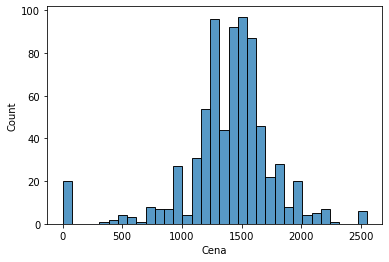

In [98]:
sns.histplot(data=df.loc[df['Wersja Iphona'] == "11"], x='Cena')

In [95]:
df.loc[(df['Wersja Iphona'] == "11") & (df['Cena'] < 1100)]

,URL ogłoszenia,Tytuł,Miejsce,Data wstawienia,Wersja Iphona,Cena,Stan,Czy odświeżano ogłoszenie?,Negocjacje
3,https://www.olx.pl/d/oferta/iphone-11-4gb-128-...,iphone 11 4gb/128,Wołomin,27 marca 2023,11,750.0,Używane,False,False
4,https://www.olx.pl/d/oferta/iphone-11-64gb-cza...,iphone 11 64gb czarny,Warszawa,27 marca 2023,11,900.0,Używane,False,False
5,https://www.olx.pl/d/oferta/iphone-11-stan-bdb...,iphone 11 stan bdb używane,Łódź,27 marca 2023,11,800.0,Używane,False,False
7,https://www.olx.pl/d/oferta/iphone-11-uzywany-...,iphone 11 używany fioletowy stan bardzo dobry,Suwałki,27 marca 2023,11,950.0,Używane,False,False
9,https://www.olx.pl/d/oferta/iphone-11-64gb-jak...,iphone 11 64gb jak nowy okazja,Łódź,27 marca 2023,11,980.0,Używane,False,False
...,...,...,...,...,...,...,...,...,...
2419,https://www.olx.pl/d/oferta/case-do-iphone-11-...,case do iphone 11 x 5 sztuk,Wrocław,27 marca 2023,11,40.0,Nowe,False,True
4584,https://www.olx.pl/d/oferta/etui-silikonowe-ca...,etui silikonowe case pokrowiec na iphone 11 12 13,Warszawa,27 marca 2023,11,30.0,Nowe,False,False
4818,https://www.olx.pl/d/oferta/etiu-z-czaszka-na-...,"etiu z czaszką na iphone 11,12,13,14",Łask,27 marca 2023,11,28.0,Nowe,False,False
4893,https://www.olx.pl/d/oferta/iphone-11-12-13-za...,iphone 11 12 13 zamiana,Sucha Górna,27 marca 2023,11,0.0,Używane,False,False


## Etap 2: Czyszczenie i przygotowanie danych
Po pobraniu danych wykonamy ich analizę, dokonując czyszczenia i przygotowania ich do dalszej pracy. Usuniemy duplikaty, brakujące wartości, a także znormalizujemy niektóre dane.

In [99]:
len(df["URL ogłoszenia"].unique())

6008

In [101]:
df = df.drop_duplicates(subset=["URL ogłoszenia", "Tytuł"],keep="last")

In [104]:
df

,URL ogłoszenia,Tytuł,Miejsce,Data wstawienia,Wersja Iphona,Cena,Stan,Czy odświeżano ogłoszenie?,Negocjacje
3,https://www.olx.pl/d/oferta/iphone-11-4gb-128-...,iphone 11 4gb/128,Wołomin,27 marca 2023,11,750.0,Używane,False,False
4,https://www.olx.pl/d/oferta/iphone-11-64gb-cza...,iphone 11 64gb czarny,Warszawa,27 marca 2023,11,900.0,Używane,False,False
5,https://www.olx.pl/d/oferta/iphone-11-stan-bdb...,iphone 11 stan bdb używane,Łódź,27 marca 2023,11,800.0,Używane,False,False
6,https://www.olx.pl/d/oferta/iphone-11-white-12...,iphone 11 white 128 gb,Opole,27 marca 2023,11,1500.0,Używane,False,True
7,https://www.olx.pl/d/oferta/iphone-11-uzywany-...,iphone 11 używany fioletowy stan bardzo dobry,Suwałki,27 marca 2023,11,950.0,Używane,False,False
...,...,...,...,...,...,...,...,...,...
7396,https://www.olx.pl/d/oferta/apple-iphone-xs-64...,apple iphone xs 64gb gold,Wrocław,27 marca 2023,xs,1299.0,Używane,False,False
7397,https://www.olx.pl/d/oferta/iphone-xs-ideal-CI...,iphone xs •ideał•,Gorzów Wielkopolski,27 marca 2023,xs,1500.0,Używane,False,False
7398,https://www.olx.pl/d/oferta/iphone-xs-max-256-...,iphone xs max 256 gb,Poznań,27 marca 2023,xs max,1300.0,Używane,False,False
7399,https://www.olx.pl/d/oferta/iphone-xs-256-gb-C...,iphone xs 256 gb,Janów,27 marca 2023,xs,1450.0,Używane,False,False


In [106]:
#df.to_csv('iphony27marzec.csv')

In [3]:
df =pd.read_csv('iphony27marzec.csv')

In [4]:
df = df.drop(df.columns[0], axis=1)

In [5]:
df

,URL ogłoszenia,Tytuł,Miejsce,Data wstawienia,Wersja Iphona,Cena,Stan,Czy odświeżano ogłoszenie?,Negocjacje
0,https://www.olx.pl/d/oferta/iphone-11-4gb-128-...,iphone 11 4gb/128,Wołomin,27 marca 2023,11,750.0,Używane,False,False
1,https://www.olx.pl/d/oferta/iphone-11-64gb-cza...,iphone 11 64gb czarny,Warszawa,27 marca 2023,11,900.0,Używane,False,False
2,https://www.olx.pl/d/oferta/iphone-11-stan-bdb...,iphone 11 stan bdb używane,Łódź,27 marca 2023,11,800.0,Używane,False,False
3,https://www.olx.pl/d/oferta/iphone-11-white-12...,iphone 11 white 128 gb,Opole,27 marca 2023,11,1500.0,Używane,False,True
4,https://www.olx.pl/d/oferta/iphone-11-uzywany-...,iphone 11 używany fioletowy stan bardzo dobry,Suwałki,27 marca 2023,11,950.0,Używane,False,False
...,...,...,...,...,...,...,...,...,...
6003,https://www.olx.pl/d/oferta/apple-iphone-xs-64...,apple iphone xs 64gb gold,Wrocław,27 marca 2023,xs,1299.0,Używane,False,False
6004,https://www.olx.pl/d/oferta/iphone-xs-ideal-CI...,iphone xs •ideał•,Gorzów Wielkopolski,27 marca 2023,xs,1500.0,Używane,False,False
6005,https://www.olx.pl/d/oferta/iphone-xs-max-256-...,iphone xs max 256 gb,Poznań,27 marca 2023,xs max,1300.0,Używane,False,False
6006,https://www.olx.pl/d/oferta/iphone-xs-256-gb-C...,iphone xs 256 gb,Janów,27 marca 2023,xs,1450.0,Używane,False,False


In [6]:
# Zliczanie wystąpień każdej wersji iPhone'a
counts = df['Wersja Iphona'].value_counts()

# Wybieranie wersji iPhone'a, które występują co najmniej 100 razy
valid_versions = counts[counts >= 100].index

# Wybieranie wierszy, które zawierają niewłaściwe wersje iPhone'a
invalid_rows = ~df['Wersja Iphona'].isin(valid_versions)

# Usuwanie wierszy zawierających niewłaściwe wersje iPhone'a
df = df.drop(index=df[invalid_rows].index)

# Wyświetlanie wyniku
df

,URL ogłoszenia,Tytuł,Miejsce,Data wstawienia,Wersja Iphona,Cena,Stan,Czy odświeżano ogłoszenie?,Negocjacje
0,https://www.olx.pl/d/oferta/iphone-11-4gb-128-...,iphone 11 4gb/128,Wołomin,27 marca 2023,11,750.0,Używane,False,False
1,https://www.olx.pl/d/oferta/iphone-11-64gb-cza...,iphone 11 64gb czarny,Warszawa,27 marca 2023,11,900.0,Używane,False,False
2,https://www.olx.pl/d/oferta/iphone-11-stan-bdb...,iphone 11 stan bdb używane,Łódź,27 marca 2023,11,800.0,Używane,False,False
3,https://www.olx.pl/d/oferta/iphone-11-white-12...,iphone 11 white 128 gb,Opole,27 marca 2023,11,1500.0,Używane,False,True
4,https://www.olx.pl/d/oferta/iphone-11-uzywany-...,iphone 11 używany fioletowy stan bardzo dobry,Suwałki,27 marca 2023,11,950.0,Używane,False,False
...,...,...,...,...,...,...,...,...,...
6003,https://www.olx.pl/d/oferta/apple-iphone-xs-64...,apple iphone xs 64gb gold,Wrocław,27 marca 2023,xs,1299.0,Używane,False,False
6004,https://www.olx.pl/d/oferta/iphone-xs-ideal-CI...,iphone xs •ideał•,Gorzów Wielkopolski,27 marca 2023,xs,1500.0,Używane,False,False
6005,https://www.olx.pl/d/oferta/iphone-xs-max-256-...,iphone xs max 256 gb,Poznań,27 marca 2023,xs max,1300.0,Używane,False,False
6006,https://www.olx.pl/d/oferta/iphone-xs-256-gb-C...,iphone xs 256 gb,Janów,27 marca 2023,xs,1450.0,Używane,False,False


In [7]:
df.groupby('Stan')['Cena'].describe()

,count,mean,std,min,25%,50%,75%,max
Stan,,,,,,,,
Nowe,421.0,2460.793254,1689.726261,0.0,450.0,3000.0,3500.0,6499.0
Uszkodzone,145.0,636.496552,597.396541,0.0,300.0,500.0,720.0,3800.0
Używane,5144.0,1669.033173,1138.238862,0.0,850.0,1300.0,2299.0,18900.0
x,2.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [8]:
df = df.drop(df[df['Stan'] == 'x'].index)

In [9]:
df_uzywane = df.loc[df['Stan'] == 'Używane']

In [10]:
df_uzywane['Wersja Iphona'].unique()

array(['11', '11 pro', '11 pro max', 'x', '12 mini', '8 plus', '13 pro',
       '13 mini', '12 pro', '12', 'xs', '8', '12 pro max', '13',
       '13 pro max', 'xs max'], dtype=object)

<AxesSubplot:xlabel='Cena', ylabel='Count'>

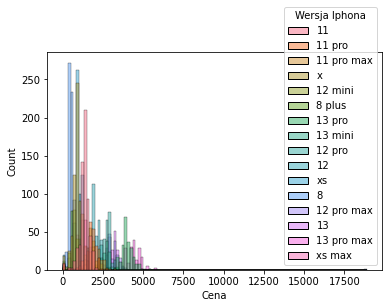

In [11]:
sns.histplot(data=df_uzywane, x='Cena', hue='Wersja Iphona')

In [12]:
# Wyznaczanie średniej i odchylenia standardowego dla kolumny 'price'
mean = df_uzywane['Cena'].mean()
std = df_uzywane['Cena'].std()

# Wyznaczanie dolnego i górnego progu cen
lower_bound = mean - 3 * std
upper_bound = mean + 3 * std

# Wybieranie wierszy, które zawierają ceny mieszczące się między dolnym a górnym progiem
valid_rows = (df_uzywane['Cena'] >= lower_bound) & (df_uzywane['Cena'] <= upper_bound)
df_uzywane = df_uzywane[valid_rows]

# Wyświetlanie wyniku
df_uzywane

,URL ogłoszenia,Tytuł,Miejsce,Data wstawienia,Wersja Iphona,Cena,Stan,Czy odświeżano ogłoszenie?,Negocjacje
0,https://www.olx.pl/d/oferta/iphone-11-4gb-128-...,iphone 11 4gb/128,Wołomin,27 marca 2023,11,750.0,Używane,False,False
1,https://www.olx.pl/d/oferta/iphone-11-64gb-cza...,iphone 11 64gb czarny,Warszawa,27 marca 2023,11,900.0,Używane,False,False
2,https://www.olx.pl/d/oferta/iphone-11-stan-bdb...,iphone 11 stan bdb używane,Łódź,27 marca 2023,11,800.0,Używane,False,False
3,https://www.olx.pl/d/oferta/iphone-11-white-12...,iphone 11 white 128 gb,Opole,27 marca 2023,11,1500.0,Używane,False,True
4,https://www.olx.pl/d/oferta/iphone-11-uzywany-...,iphone 11 używany fioletowy stan bardzo dobry,Suwałki,27 marca 2023,11,950.0,Używane,False,False
...,...,...,...,...,...,...,...,...,...
6003,https://www.olx.pl/d/oferta/apple-iphone-xs-64...,apple iphone xs 64gb gold,Wrocław,27 marca 2023,xs,1299.0,Używane,False,False
6004,https://www.olx.pl/d/oferta/iphone-xs-ideal-CI...,iphone xs •ideał•,Gorzów Wielkopolski,27 marca 2023,xs,1500.0,Używane,False,False
6005,https://www.olx.pl/d/oferta/iphone-xs-max-256-...,iphone xs max 256 gb,Poznań,27 marca 2023,xs max,1300.0,Używane,False,False
6006,https://www.olx.pl/d/oferta/iphone-xs-256-gb-C...,iphone xs 256 gb,Janów,27 marca 2023,xs,1450.0,Używane,False,False


<AxesSubplot:xlabel='Cena', ylabel='Count'>

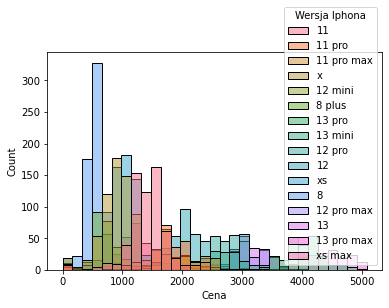

In [13]:
sns.histplot(data=df_uzywane, x='Cena', hue='Wersja Iphona')

<AxesSubplot:xlabel='Cena', ylabel='Count'>

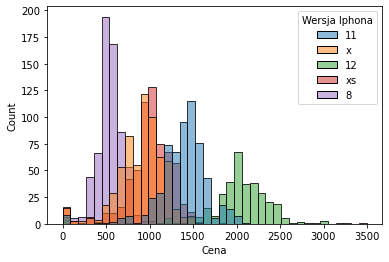

In [14]:
# Wyznacz częstości występowania każdej wersji i wybierz 5 najczęściej występujących
top_versions = df_uzywane['Wersja Iphona'].value_counts().head(5).index.tolist()

# Odfiltruj wiersze w ramce danych, aby wyświetlać tylko te zawierające 5 najczęściej występujących wersji
filtered_df = df_uzywane[df_uzywane['Wersja Iphona'].isin(top_versions)]

# Utwórz wykres histogramu dla wierszy spełniających warunek filtrowania
sns.histplot(data=filtered_df, x='Cena', hue='Wersja Iphona')

<AxesSubplot:xlabel='Wersja Iphona', ylabel='Cena'>

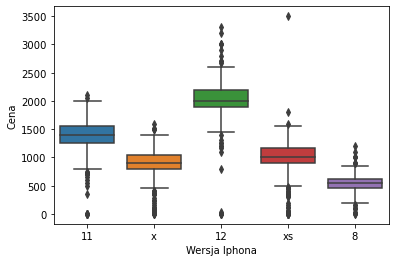

In [15]:
sns.boxplot(data=filtered_df, x='Wersja Iphona', y='Cena')

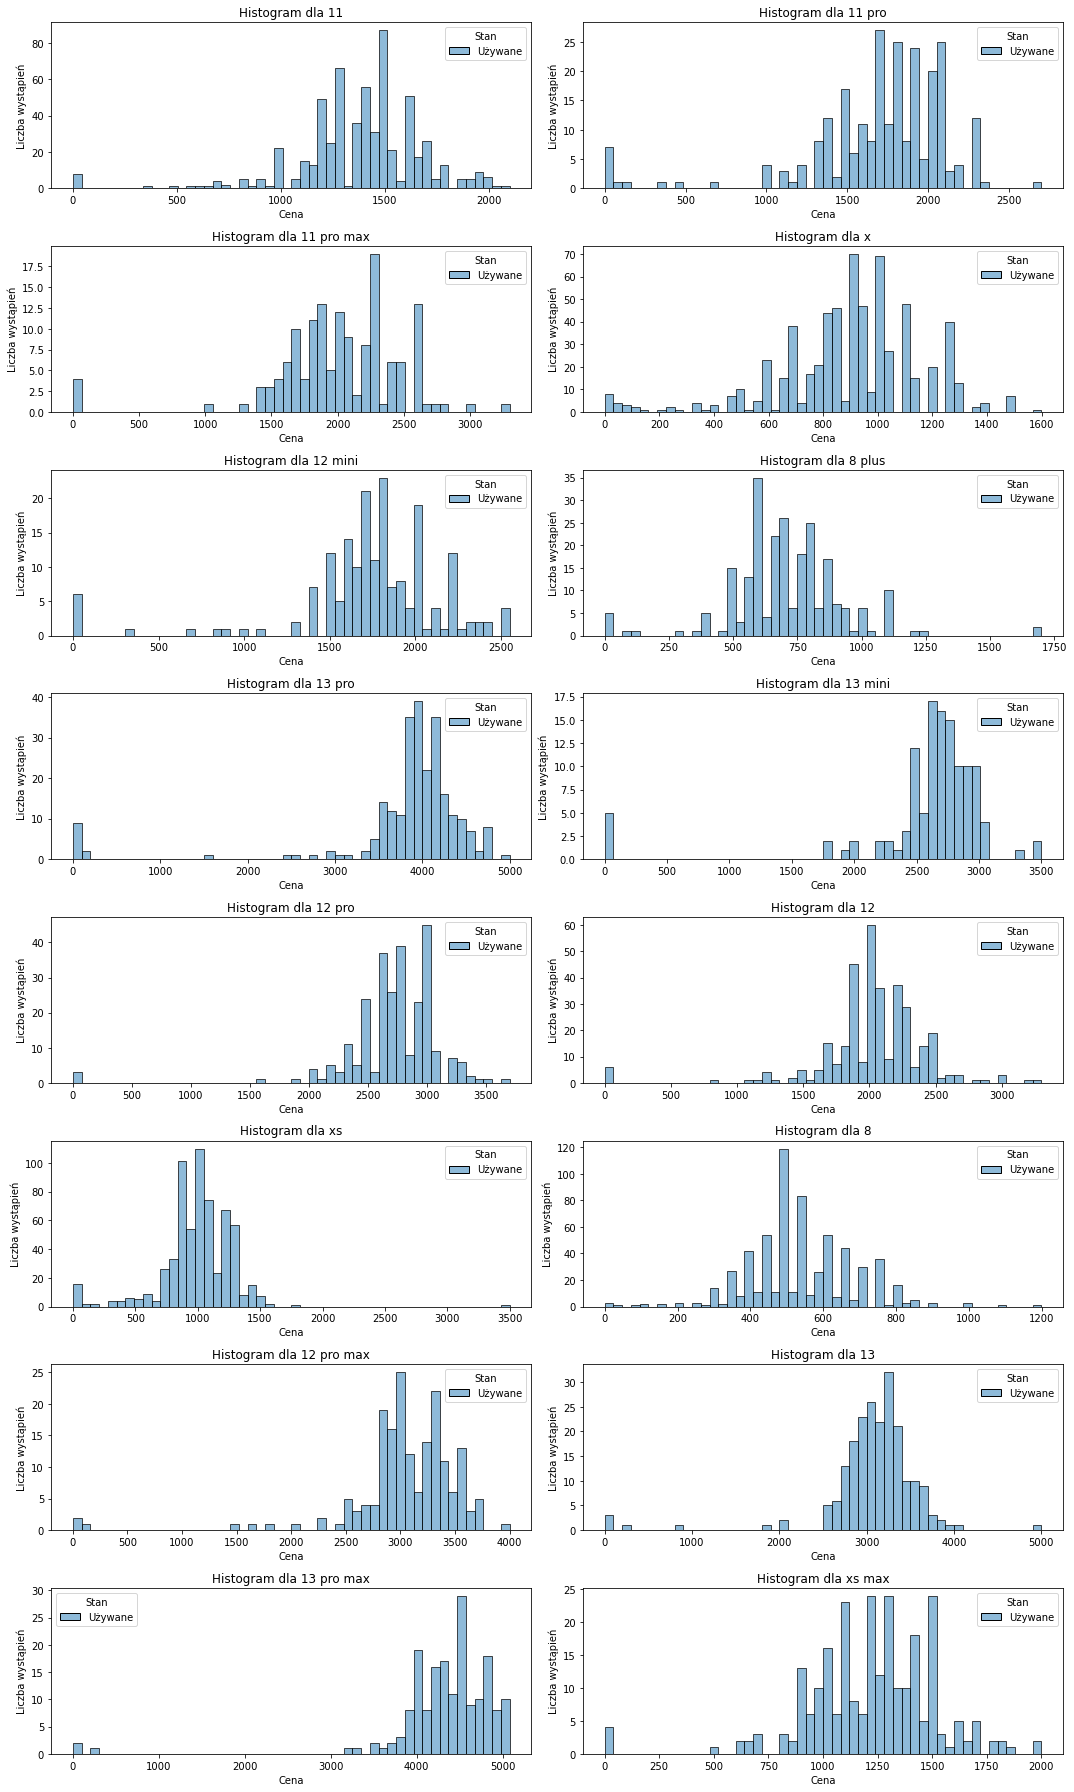

In [16]:
# Wyznacz wersje iPhone'a
iphone_versions = df_uzywane['Wersja Iphona'].unique()

# Ustaw liczbę wierszy i kolumn wykresów
nrows = 8
ncols = 2

# Ustaw rozmiar rysunku
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 25))

# Iteruj po wersjach iPhone'a i generuj wykresy histogramów
for i, version in enumerate(iphone_versions):
    row = i // ncols
    col = i % ncols
    
    # Wybierz wiersze odpowiadające danej wersji iPhone'a
    version_df = df_uzywane.loc[df_uzywane['Wersja Iphona'] == version]
    
    # Wygeneruj wykres histogramu dla ceny
    sns.histplot(data=version_df, x='Cena', hue='Stan', kde=False, bins=50, ax=axs[row, col])
    axs[row, col].set_title(f"Histogram dla {version}")
    axs[row, col].set_xlabel("Cena")
    axs[row, col].set_ylabel("Liczba wystąpień")

# Wyświetl rysunek
plt.tight_layout()
plt.show()

In [17]:
df_uzywane.loc[df_uzywane['Cena'] < 110]

,URL ogłoszenia,Tytuł,Miejsce,Data wstawienia,Wersja Iphona,Cena,Stan,Czy odświeżano ogłoszenie?,Negocjacje
101,https://www.olx.pl/d/oferta/case-iphone-11-pro...,case iphone 11 pro,Warszawa,27 marca 2023,11 pro,49.0,Używane,False,False
228,https://www.olx.pl/d/oferta/zamienie-bialego-i...,zamienię białego iphone 11,Świętoszówka,27 marca 2023,11,0.0,Używane,False,False
240,https://www.olx.pl/d/oferta/iphone-11-pro-256g...,iphone 11 pro 256gb,Poznań,27 marca 2023,11 pro,0.0,Używane,False,False
363,https://www.olx.pl/d/oferta/etui-case-iphone-1...,etui case iphone 11 pro max,Wrocław,27 marca 2023,11 pro max,30.0,Używane,False,False
364,https://www.olx.pl/d/oferta/iphone-11-64gb-etu...,iphone 11 64gb etui,Radom,27 marca 2023,11,0.0,Używane,False,False
...,...,...,...,...,...,...,...,...,...
5848,https://www.olx.pl/d/oferta/iphone-xs-max-na-c...,iphone xs max na części,Jelenia Góra,27 marca 2023,xs max,10.0,Używane,False,False
5863,https://www.olx.pl/d/oferta/power-bank-etui-ip...,power bank etui iphone xs bateria !,Barwałd Dolny,27 marca 2023,xs,50.0,Używane,False,False
5900,https://www.olx.pl/d/oferta/czarne-etui-svarow...,czarne etui svarowski iphone x/xs,Komorniki,27 marca 2023,x,60.0,Używane,False,False
5927,https://www.olx.pl/d/oferta/sp-connect-do-ipho...,sp connect do iphone x/xs,Piaseczno,20 marca 2023,x,85.0,Używane,True,True


In [18]:
df_uzywane = df_uzywane.loc[df_uzywane['Cena'] >= 300]

### Usuniecie nadmiarowych danych
Z uwagi iż za niskie ceny jak i za wysokie mogą psuć analize postanowiłem usunąc wyniki nie mieszczące się w 2 odchylenia standardowych.

In [ ]:
# Tworzenie pustej listy dla wyników
valid_dfs = []

# Iteracja po wersjach iPhone'a i wyznaczanie prógów dla każdej z nich
for version in df_uzywane['Wersja Iphona'].unique():
    # Wybieranie wierszy odpowiadających danej wersji iPhone'a
    df_version = df_uzywane.loc[df_uzywane['Wersja Iphona'] == version]
    
    # Wyznaczanie średniej i odchylenia standardowego dla kolumny 'Cena'
    mean = df_version.loc[df_version['Stan'] == 'Używane', 'Cena'].mean()
    std = df_version.loc[df_version['Stan'] == 'Używane', 'Cena'].std()
    
    # Wyznaczanie dolnego i górnego progu cen
    lower_bound = mean - 2 * std
    upper_bound = mean + 2 * std
    
    # Wybieranie wierszy, które zawierają ceny mieszczące się między dolnym a górnym progiem
    valid_rows = (df_version['Stan'] != 'x') & (df_version['Stan'] == 'Używane') & (df_version['Cena'] >= lower_bound) & (df_version['Cena'] <= upper_bound)
    valid_df = df_version[valid_rows]
    
    # Dodawanie wyniku do listy
    valid_dfs.append(valid_df)

# Łączenie wyników w jeden DataFrame
df_valid = pd.concat(valid_dfs)

In [20]:
df_valid

,URL ogłoszenia,Tytuł,Miejsce,Data wstawienia,Wersja Iphona,Cena,Stan,Czy odświeżano ogłoszenie?,Negocjacje
3,https://www.olx.pl/d/oferta/iphone-11-white-12...,iphone 11 white 128 gb,Opole,27 marca 2023,11,1500.00,Używane,False,True
4,https://www.olx.pl/d/oferta/iphone-11-uzywany-...,iphone 11 używany fioletowy stan bardzo dobry,Suwałki,27 marca 2023,11,950.00,Używane,False,False
6,https://www.olx.pl/d/oferta/iphone-11-64gb-jak...,iphone 11 64gb jak nowy okazja,Łódź,27 marca 2023,11,980.00,Używane,False,False
7,https://www.olx.pl/d/oferta/iphone-11-64gb-bez...,iphone 11 64gb bez ładowarki,Ruda Śląska,27 marca 2023,11,1200.00,Używane,False,True
8,https://www.olx.pl/d/oferta/iphone-11-white-12...,iphone 11 white 128gb super stan,Bydgoszcz,27 marca 2023,11,1250.00,Używane,False,True
...,...,...,...,...,...,...,...,...,...
5995,https://www.olx.pl/d/oferta/iphone-xs-max-64-g...,"iphone xs max 64 gb space gray , jak nowy !",Lubin,27 marca 2023,xs max,1300.00,Używane,False,True
5999,https://www.olx.pl/d/oferta/apple-iphone-xs-ma...,apple iphone xs max 64gb,Kalisz,27 marca 2023,xs max,1449.99,Używane,False,False
6000,https://www.olx.pl/d/oferta/iphone-xs-max-opis...,iphone xs max opis,Bydgoszcz,27 marca 2023,xs max,950.00,Używane,False,True
6005,https://www.olx.pl/d/oferta/iphone-xs-max-256-...,iphone xs max 256 gb,Poznań,27 marca 2023,xs max,1300.00,Używane,False,False


## Etap 3 Prezentacja wyników

Zaprezentowanie historgramów do każdej wersji iphona jak i boxplota

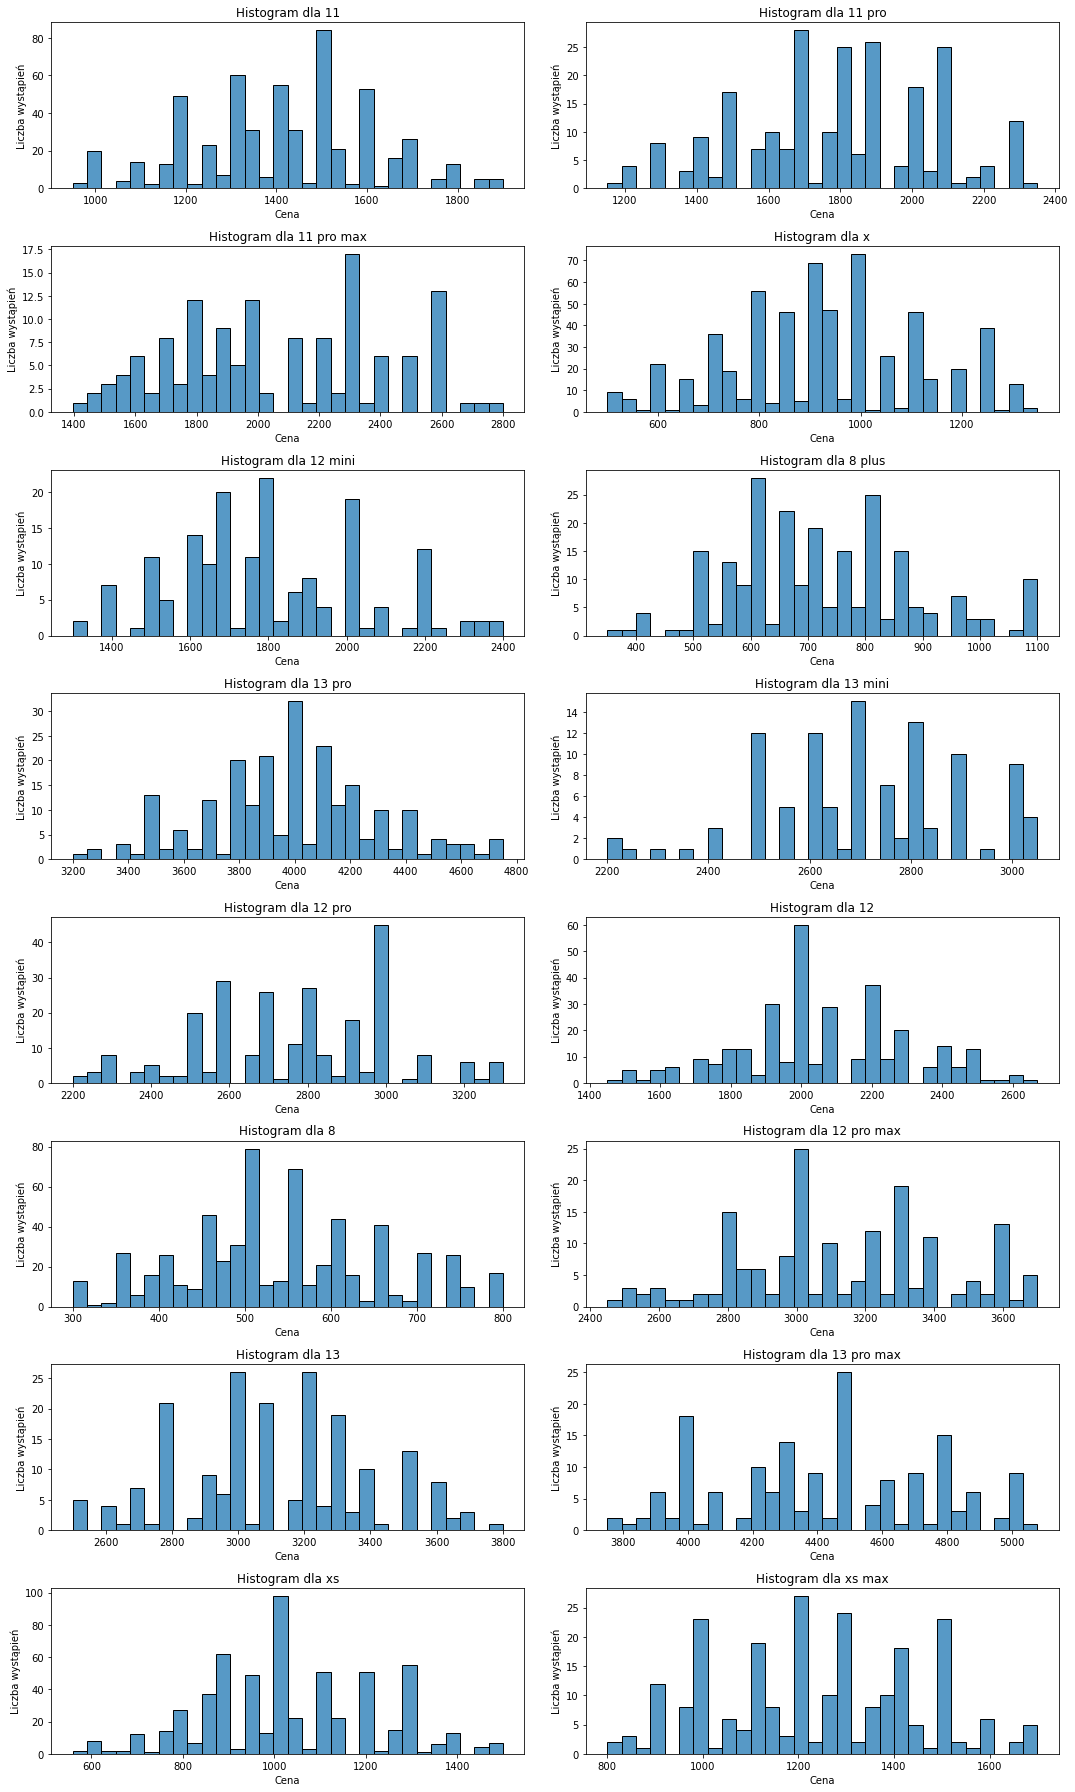

In [21]:
# Wyznacz wersje iPhone'a
iphone_versions = df_valid['Wersja Iphona'].unique()

# Ustaw liczbę wierszy i kolumn wykresów
nrows = 8
ncols = 2

# Ustaw rozmiar rysunku
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 25))

# Iteruj po wersjach iPhone'a i generuj wykresy histogramów
for i, version in enumerate(iphone_versions):
    row = i // ncols
    col = i % ncols
    
    # Wybierz wiersze odpowiadające danej wersji iPhone'a
    version_df = df_valid.loc[df_valid['Wersja Iphona'] == version]
    
    # Wygeneruj wykres histogramu dla ceny
    sns.histplot(data=version_df, x='Cena', kde=False, bins=30, ax=axs[row, col])
    axs[row, col].set_title(f"Histogram dla {version}")
    axs[row, col].set_xlabel("Cena")
    axs[row, col].set_ylabel("Liczba wystąpień")

# Wyświetl rysunek
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='Wersja Iphona', ylabel='Cena'>

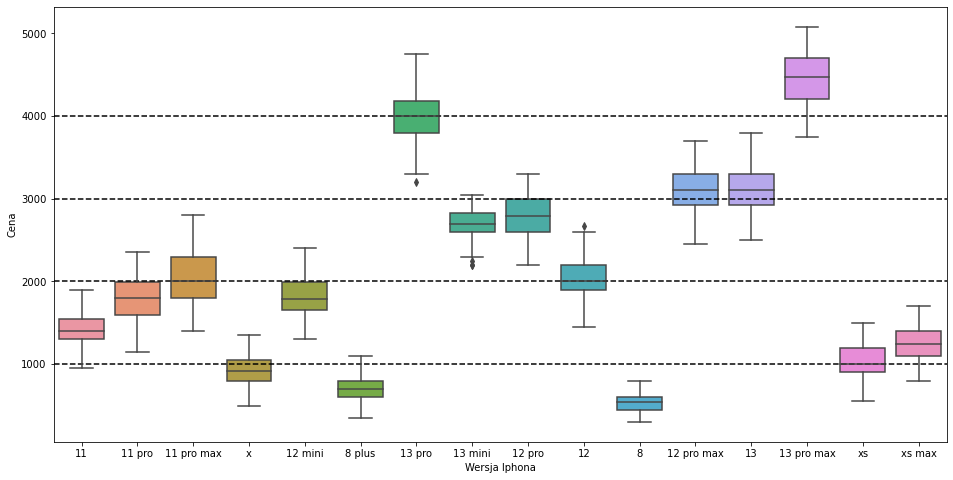

In [44]:
plt.figure(figsize=(16, 8))
plt.axhline(y=1000, color='black', linestyle='--')
plt.axhline(y=2000, color='black', linestyle='--')
plt.axhline(y=3000, color='black', linestyle='--')
plt.axhline(y=4000, color='black', linestyle='--')
sns.boxplot(data=df_valid, x='Wersja Iphona', y='Cena')

In [29]:
# Ustawienie liczby najtańszych produktów, które mają być wyświetlone dla każdej wersji iPhone'a
n = 10

# Zgrupowanie po kolumnie 'Wersja Iphona' i wybranie 10 najtańszych produktów dla każdej grupy
df_top_10 = (df_valid.groupby('Wersja Iphona')
             .apply(lambda x: x.nsmallest(n, 'Cena'))
             .reset_index(drop=True))


In [30]:
pd.set_option('display.max_colwidth', None)

In [31]:
# Ustawienie liczby najtańszych produktów, które mają być wyświetlone dla każdej wersji iPhone'a
n = 10

# Zgrupowanie po kolumnie 'Wersja Iphona' i wybranie 10 najtańszych produktów dla każdej grupy
df_top_10 = (df_valid.groupby('Wersja Iphona')
             .apply(lambda x: x.nsmallest(n, 'Cena'))
             .reset_index(drop=True))

# Wyświetlenie top 10 linków dla każdej wersji iPhone'a
for model in df_top_10['Wersja Iphona'].unique():
    print(f"\nTop {n} najtańszych produktów dla {model}:\n")
    for index, row in df_top_10[df_top_10['Wersja Iphona'] == model].iterrows():
        print(f"{index+1}. {row['URL ogłoszenia']}")


Top 10 najtańszych produktów dla 11:

1. https://www.olx.pl/d/oferta/iphone-11-uzywany-fioletowy-stan-bardzo-dobry-CID99-IDTKO1G.html
2. https://www.olx.pl/d/oferta/iphone-11-64gb-fioletowy-CID99-IDTF4zm.html
3. https://www.olx.pl/d/oferta/iphone-11-64gb-jak-nowy-okazja-CID99-IDTEYmz.html
4. https://www.olx.pl/d/oferta/sprzedam-iphone-11-xs-64-gb-CID99-IDTOQBC.html
5. https://www.olx.pl/d/oferta/iphone-11-64gb-mietowy-CID99-IDTO7fJ.html
6. https://www.olx.pl/d/oferta/iphone-11-bialy-64-gb-CID99-IDTHslr.html
7. https://www.olx.pl/d/oferta/iphone-11-black-64gb-CID99-IDTNb8t.html
8. https://www.olx.pl/d/oferta/iphone-11-zamienie-z-doplata-lub-sprzedam-CID99-IDTKKzc.html
9. https://www.olx.pl/d/oferta/iphone-11-128gb-czarny-CID99-IDTJWeV.html
10. https://www.olx.pl/d/oferta/rezerwacja-iphone-11-bialy-128-gb-CID99-IDTOajC.html

Top 10 najtańszych produktów dla 11 pro:

11. https://www.olx.pl/d/oferta/iphone-11-64gb-product-red-sprawny-bez-face-id-CID99-IDSU9vd.html
12. https://www.olx.pl/d